# Predicting Football Player Positions Using Performance Statistics from Top 5 European Leagues (2023–2024)

## Overview
This notebook demonstrates how to build a machine learning model to predict football player positions based on their performance statistics. The dataset contains player statistics from the top 5 European leagues for the 2023-2024 season.

## Table of Contents
1. [Data Loading and Exploration](#1-data-loading-and-exploration)
2. [Data Preprocessing](#2-data-preprocessing)
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
4. [Feature Engineering and Model Preparation](#4-feature-engineering-and-model-preparation)
5. [Model Training and Cross-Validation](#5-model-training-and-cross-validation)
6. [Model Evaluation](#6-model-evaluation)
7. [Feature Importance Analysis](#7-feature-importance-analysis)
8. [Model Serialization](#8-model-serialization)


## Libraries and Setup


In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import joblib

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Set plot style
sns.set_style("whitegrid")

# Create artifacts directory for saving outputs
pathlib.Path("artifacts").mkdir(exist_ok=True)


## 1. Data Loading and Exploration
Load the dataset and explore its basic properties.


In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('data/top5-players.csv')

# Display the shape of the dataset
print(f"Dataset shape: {df.shape} (rows, columns)")

# Display column names
print("\nColumn names:")
print(df.columns.tolist())

# Display the first five rows
print("\nFirst five rows:")
print(df.head())

# Examine the target variable (player positions)
print("\nUnique values in the 'Pos' column:")
pos_counts = df['Pos'].value_counts()
print(pos_counts)

# Extract the primary position (first position listed)
df['Primary_Position'] = df['Pos'].str.split(',').str[0].str.strip()

# Show distribution of primary positions
print("\nDistribution of primary positions:")
primary_pos_counts = df['Primary_Position'].value_counts()
print(primary_pos_counts)
print(f"Number of unique primary positions: {df['Primary_Position'].nunique()}")


Dataset shape: (2852, 37) (rows, columns)

Column names:
['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK_90', 'xG_90', 'xAG_90', 'xG+xAG_90', 'npxG_90', 'npxG+xAG_90']

First five rows:
   Rk             Player   Nation    Pos           Squad                Comp  \
0   1         Max Aarons  eng ENG     DF     Bournemouth  eng Premier League   
1   2   Brenden Aaronson   us USA  MF,FW    Union Berlin       de Bundesliga   
2   3    Paxten Aaronson   us USA     MF  Eint Frankfurt       de Bundesliga   
3   4  Keyliane Abdallah   fr FRA     FW       Marseille          fr Ligue 1   
4   5   Yunis Abdelhamid   ma MAR     DF           Reims          fr Ligue 1   

    Age    Born  MP  Starts  ...  Gls_90  Ast_90  G+A_90  G-PK_90  G+A-PK_90  \
0  23.0  2000.0  20      13  ...    0.0

## 2. Data Preprocessing
Clean and prepare the data for modeling.


In [3]:
# Create a cleaned DataFrame
df_clean = df.copy()

# 1. Remove rows where 'Pos' is NaN
print("1. Removing rows where 'Pos' is NaN...")
print(f"Number of rows before removing NaN Pos: {df_clean.shape[0]}")
df_clean = df_clean[df_clean['Pos'].notna()]
print(f"Number of rows after removing NaN Pos: {df_clean.shape[0]}")

# 2. Simplify 'Pos' to first token before comma and strip whitespace
print("\n2. Simplifying 'Pos' to first token before comma and stripping whitespace...")
df_clean['Primary_Position'] = df_clean['Pos'].str.split(',').str[0].str.strip()

# 3. Drop identifier columns
print("\n3. Dropping identifier columns...")
identifier_columns = ['Rk', 'Player', 'Born']
df_clean = df_clean.drop(columns=identifier_columns)
print(f"Columns dropped: {identifier_columns}")
print(f"Remaining columns: {df_clean.columns.tolist()}")

# 4. Check for missing values
print("\n4. Checking for missing values...")
missing_values = df_clean.isnull().sum()
print(missing_values[missing_values > 0])

# 5. Impute missing values
print("\n5. Imputing missing values...")
# Identify numerical and categorical columns
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns

# Impute numeric NaNs with median
for col in numerical_cols:
    if df_clean[col].isnull().sum() > 0:
        median_value = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_value)
        print(f"Imputed {col} with median: {median_value}")

# Impute categorical NaNs with "Unknown"
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna("Unknown")
        print(f"Imputed {col} with 'Unknown'")

# Verify no more missing values
print("\nVerifying no more missing values:")
print(df_clean.isnull().sum().sum(), "missing values remaining")

# Show class distribution after cleaning
print("\n6. Class distribution after cleaning:")
print(df_clean['Primary_Position'].value_counts())
print(f"Number of unique primary positions: {df_clean['Primary_Position'].nunique()}")


1. Removing rows where 'Pos' is NaN...
Number of rows before removing NaN Pos: 2852
Number of rows after removing NaN Pos: 2852

2. Simplifying 'Pos' to first token before comma and stripping whitespace...

3. Dropping identifier columns...
Columns dropped: ['Rk', 'Player', 'Born']
Remaining columns: ['Nation', 'Pos', 'Squad', 'Comp', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK_90', 'xG_90', 'xAG_90', 'xG+xAG_90', 'npxG_90', 'npxG+xAG_90', 'Primary_Position']

4. Checking for missing values...
Nation         3
Age            4
xG             1
npxG           1
xAG            1
npxG+xAG       1
PrgC           1
PrgP           1
PrgR           1
xG_90          1
xAG_90         1
xG+xAG_90      1
npxG_90        1
npxG+xAG_90    1
dtype: int64

5. Imputing missing values...
Imputed Age with median: 25.0
Imputed xG with median: 0.7
Im

## 3. Exploratory Data Analysis
Visualize the data to gain insights.


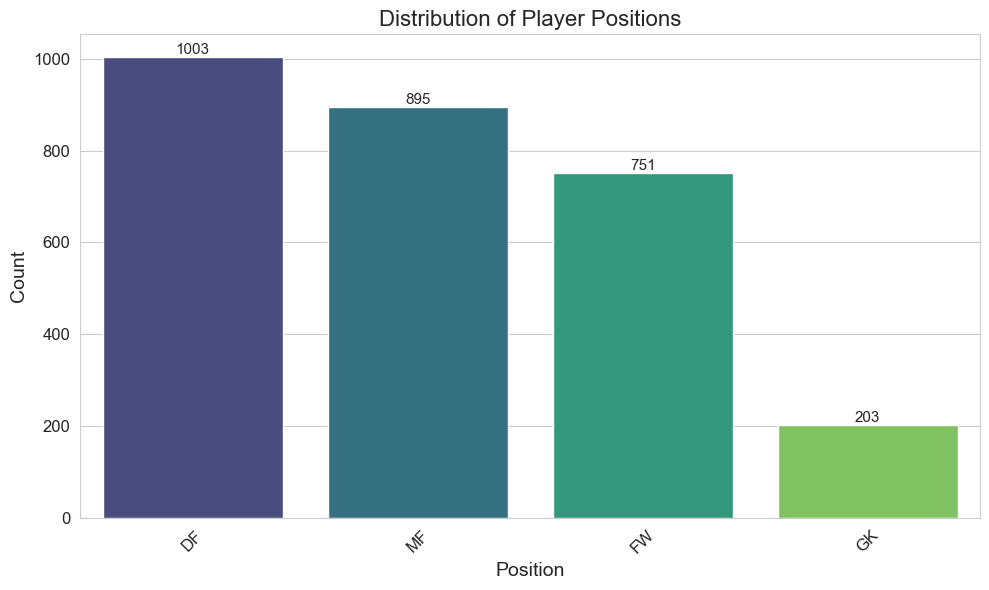

In [4]:
# 1. Distribution of Player Positions
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Primary_Position', hue='Primary_Position', data=df_clean, palette='viridis', legend=False)
plt.title('Distribution of Player Positions', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()


/var/folders/04/4pl4fqkj38xfn1m5c9rv_h2c0000gn/T/ipykernel_62657/3778740324.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Primary_Position', y='Age', data=df_clean, palette='Set2')


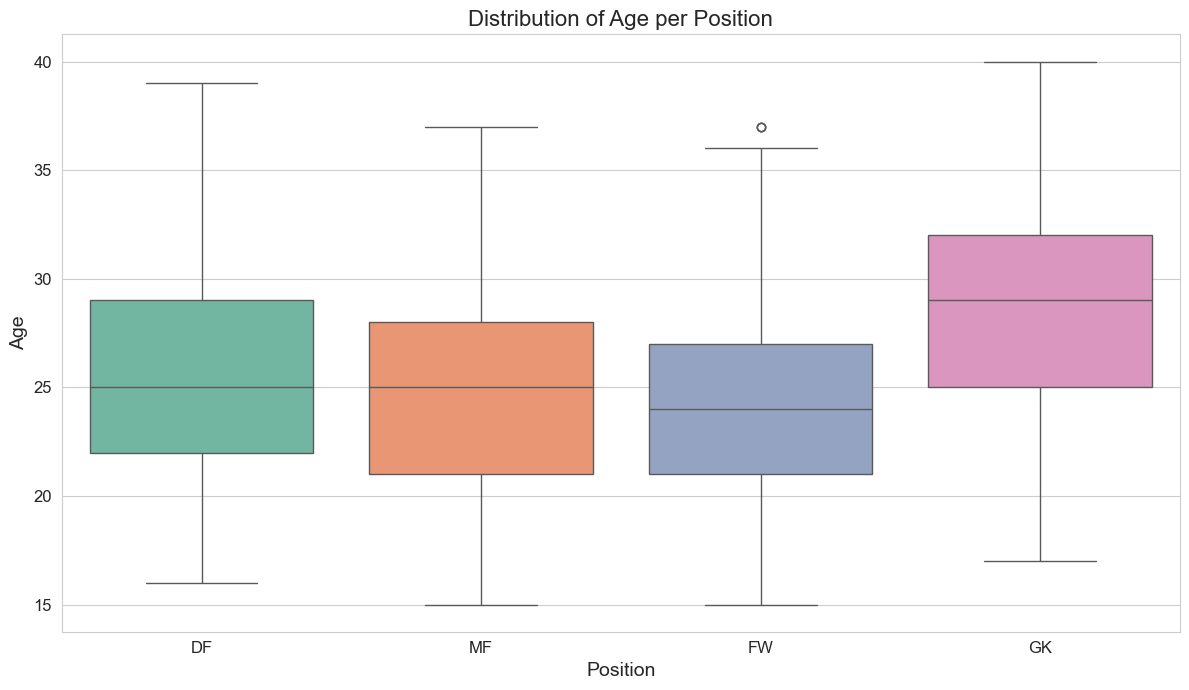

In [5]:
# 2. Distribution of Age per Position
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Primary_Position', y='Age', data=df_clean, palette='Set2')
plt.title('Distribution of Age per Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/04/4pl4fqkj38xfn1m5c9rv_h2c0000gn/T/ipykernel_62657/2452122051.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Primary_Position', y='Min', data=df_clean, palette='Set3')


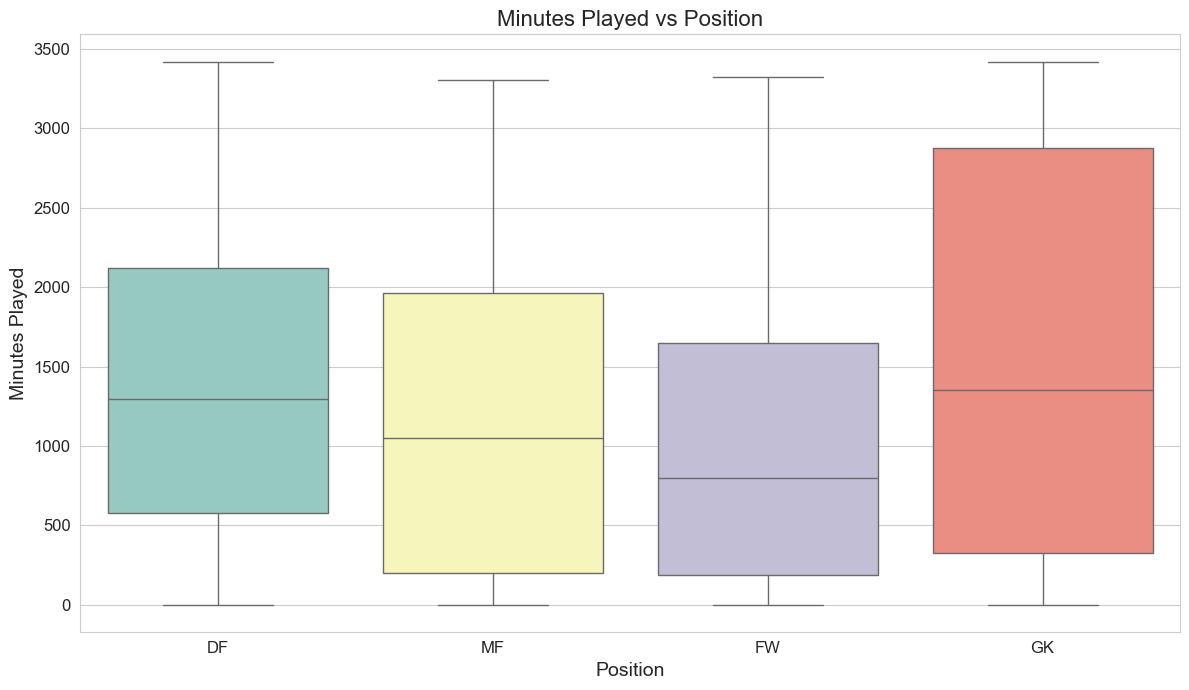

In [6]:
# 3. Minutes Played vs Position
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Primary_Position', y='Min', data=df_clean, palette='Set3')
plt.title('Minutes Played vs Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Minutes Played', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


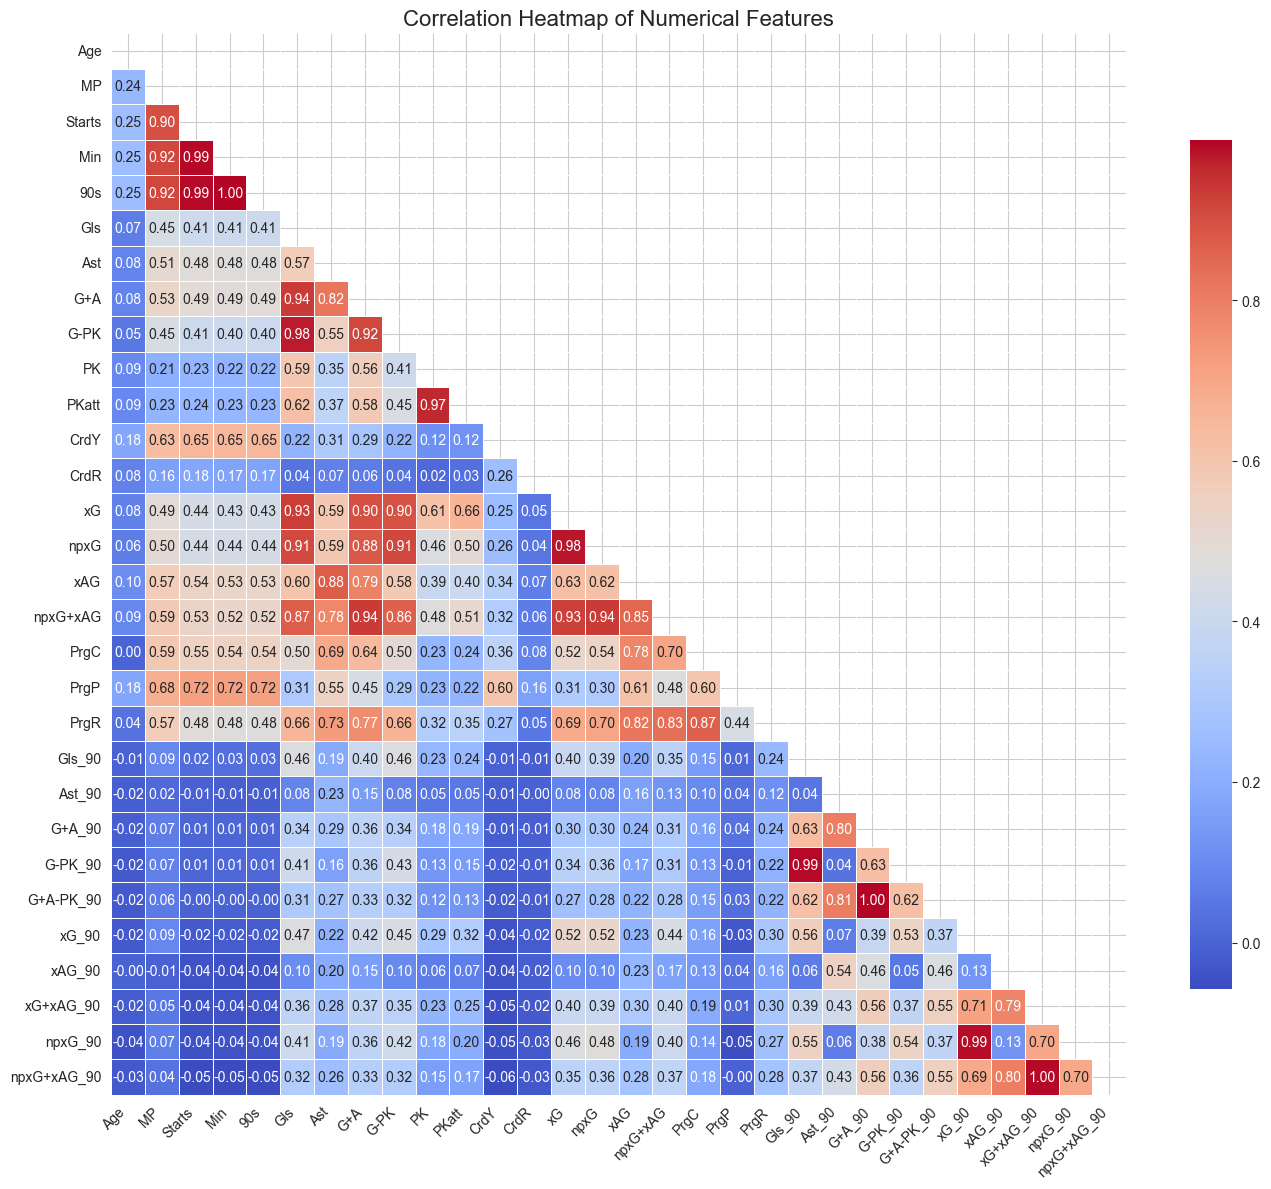

In [7]:
# 4. Heatmap of Numerical Feature Correlations
plt.figure(figsize=(14, 12))
# Select only numerical columns for correlation
numerical_features = df_clean.select_dtypes(include=['int64', 'float64'])
# Calculate correlation matrix
corr_matrix = numerical_features.corr()
# Create heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                 linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


## 4. Feature Engineering and Model Preparation
Prepare features and target variable for modeling.


In [8]:
# 1. Separate features (X) and target (y)
print("Separating features (X) and target (y)...")
target_column = 'Primary_Position'
# Columns to exclude from features
exclude_columns = ['Pos', target_column]  # Exclude original Pos and target column
# Get all feature columns
X = df_clean.drop(columns=exclude_columns)
y = df_clean[target_column]

# Encode the target variable using LabelEncoder
print("\nEncoding target variable...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"Original classes: {label_encoder.classes_}")
print(f"Encoded classes: {np.unique(y_encoded)}")


Separating features (X) and target (y)...

Encoding target variable...
Original classes: ['DF' 'FW' 'GK' 'MF']
Encoded classes: [0 1 2 3]


In [10]:
# 2. Perform 80/20 train_test_split, stratifying on y
print("Performing 80/20 train-test split, stratifying on y...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Performing 80/20 train-test split, stratifying on y...
Training set: 2281 samples
Test set: 571 samples


In [11]:
# 3. Build a ColumnTransformer for preprocessing
print("Building a ColumnTransformer for preprocessing...")
# Identify numerical and categorical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns}")
print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns}")

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ],
    remainder='drop'  # Drop columns not specified in transformers
)


Building a ColumnTransformer for preprocessing...
Numerical columns (30): ['Age', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK_90', 'xG_90', 'xAG_90', 'xG+xAG_90', 'npxG_90', 'npxG+xAG_90']
Categorical columns (3): ['Nation', 'Squad', 'Comp']


In [12]:
# 4. Create a Pipeline with a placeholder classifier
print("Creating a Pipeline with a placeholder classifier...")
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 5. Print X_train shape and pipeline steps
print(f"\nX_train shape: {X_train.shape}")
print("Pipeline steps:")
for name, step in pipeline.steps:
    print(f"- {name}: {type(step).__name__}")


Creating a Pipeline with a placeholder classifier...

X_train shape: (2281, 33)
Pipeline steps:
- preprocessor: ColumnTransformer
- classifier: LogisticRegression


## 5. Model Training and Cross-Validation
Train and cross-validate multiple models to find the best performer.


In [13]:
# Initialize classifiers with specified parameters
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=400, random_state=42),
    'XGBClassifier': XGBClassifier(n_estimators=600, learning_rate=0.05, subsample=0.8, 
                                  colsample_bytree=0.8, random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=7)
}

# Dictionary to store cross-validation results
cv_results = {
    'Classifier': [],
    'Mean Accuracy': [],
    'Mean Macro-F1': []
}

# Define cross-validation strategy: 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [14]:
# Perform cross-validation for each classifier
for name, clf in classifiers.items():
    print(f"\nCross-validating {name}...")
    
    # Create a pipeline with the preprocessor and classifier
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Perform cross-validation
    cv_scores = cross_validate(
        model_pipeline, X_train, y_train, 
        cv=cv,
        scoring=['accuracy', 'f1_macro'],
        return_train_score=False
    )
    
    # Calculate mean scores
    mean_accuracy = cv_scores['test_accuracy'].mean()
    mean_f1 = cv_scores['test_f1_macro'].mean()
    
    # Store results
    cv_results['Classifier'].append(name)
    cv_results['Mean Accuracy'].append(mean_accuracy)
    cv_results['Mean Macro-F1'].append(mean_f1)
    
    print(f"Mean Accuracy: {mean_accuracy:.4f}")
    print(f"Mean Macro-F1: {mean_f1:.4f}")



Cross-validating LogisticRegression...
Mean Accuracy: 0.6900
Mean Macro-F1: 0.7177

Cross-validating RandomForestClassifier...
Mean Accuracy: 0.6874
Mean Macro-F1: 0.7316

Cross-validating XGBClassifier...
Mean Accuracy: 0.7295
Mean Macro-F1: 0.7714

Cross-validating KNeighborsClassifier...
Mean Accuracy: 0.6006
Mean Macro-F1: 0.6150


In [15]:
# Display results in a comparison table
print("Comparison of Cross-Validation Performance:")
cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values(by='Mean Macro-F1', ascending=False)
print(cv_results_df.to_string(index=False))

# Identify the best-performing model
best_clf_name = cv_results_df.iloc[0]['Classifier']
print(f"\nBest-performing model: {best_clf_name}")
best_clf = classifiers[best_clf_name]

# Create the best pipeline
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_clf)
])


Comparison of Cross-Validation Performance:
            Classifier  Mean Accuracy  Mean Macro-F1
         XGBClassifier       0.729509       0.771379
RandomForestClassifier       0.687421       0.731565
    LogisticRegression       0.690048       0.717734
  KNeighborsClassifier       0.600600       0.614951

Best-performing model: XGBClassifier


## 6. Model Evaluation
Evaluate the best model on the test set.


In [16]:
# 1. Fit best_clf on full training data
print(f"Fitting {best_clf_name} on full training data...")
best_pipeline.fit(X_train, y_train)

# 2. Predict on the held-out test set
print("Predicting on the held-out test set...")
y_pred = best_pipeline.predict(X_test)

# Convert encoded predictions and test labels back to original class names
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)


Fitting XGBClassifier on full training data...
Predicting on the held-out test set...


In [17]:
# 3. Show evaluation metrics
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
report = classification_report(y_test_original, y_pred_original)
print(report)

# Save classification report to text file
print("Saving classification report to artifacts/classification_report.txt...")
with open('artifacts/classification_report.txt', 'w') as f:
    f.write(f"Classification Report for {best_clf_name}\n\n")
    f.write(report)
print("Classification report saved successfully.")


Accuracy on test set: 0.7180

Classification Report:
              precision    recall  f1-score   support

          DF       0.75      0.78      0.76       201
          FW       0.72      0.77      0.74       150
          GK       0.93      0.95      0.94        41
          MF       0.62      0.56      0.59       179

    accuracy                           0.72       571
   macro avg       0.75      0.76      0.76       571
weighted avg       0.71      0.72      0.72       571

Saving classification report to artifacts/classification_report.txt...
Classification report saved successfully.



Confusion Matrix:
[[156  11   0  34]
 [  6 115   2  27]
 [  1   0  39   1]
 [ 44  34   1 100]]
Saving confusion matrix to artifacts/confusion_matrix.png...
Confusion matrix saved successfully.


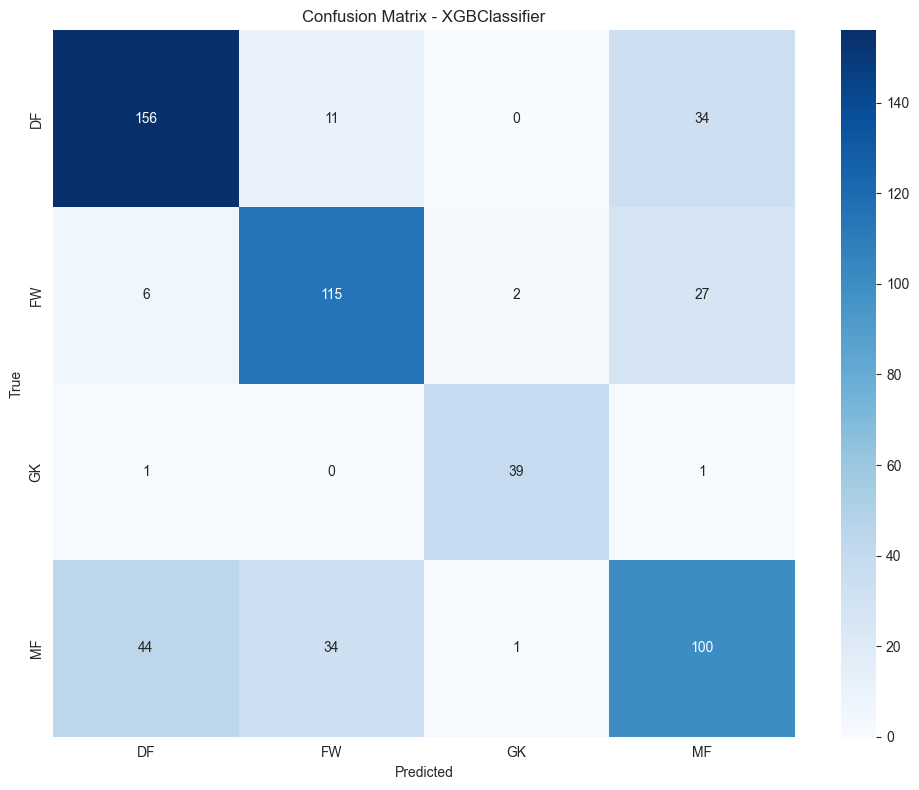

In [18]:
# Generate confusion matrix
cm = confusion_matrix(y_test_original, y_pred_original)
print("\nConfusion Matrix:")
print(cm)

# Visualize the confusion matrix using a seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), 
            yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_clf_name}')
plt.tight_layout()

# Save the confusion matrix as a PNG file
print("Saving confusion matrix to artifacts/confusion_matrix.png...")
plt.savefig('artifacts/confusion_matrix.png')
print("Confusion matrix saved successfully.")
plt.show()


## 7. Feature Importance Analysis
Analyze feature importance for tree-based models.


Computing feature importance...
XGBClassifier is tree-based, computing feature importance...

Top 15 features by importance:
            Feature  Importance
              xG_90    3.562302
            npxG_90    3.177050
               PrgR    2.080341
          xG+xAG_90    1.930620
               PrgP    1.653029
        npxG+xAG_90    1.380213
                90s    1.344700
             Starts    1.070908
                Min    1.067018
   Squad_Heidenheim    1.066081
      Nation_cm CMR    1.058777
               PrgC    1.038804
   Squad_Leverkusen    1.031435
        Squad_Lazio    1.002329
Squad_Bayern Munich    0.963628

Saving feature importance plot to artifacts/feature_importance.png...
Feature importance plot saved successfully.


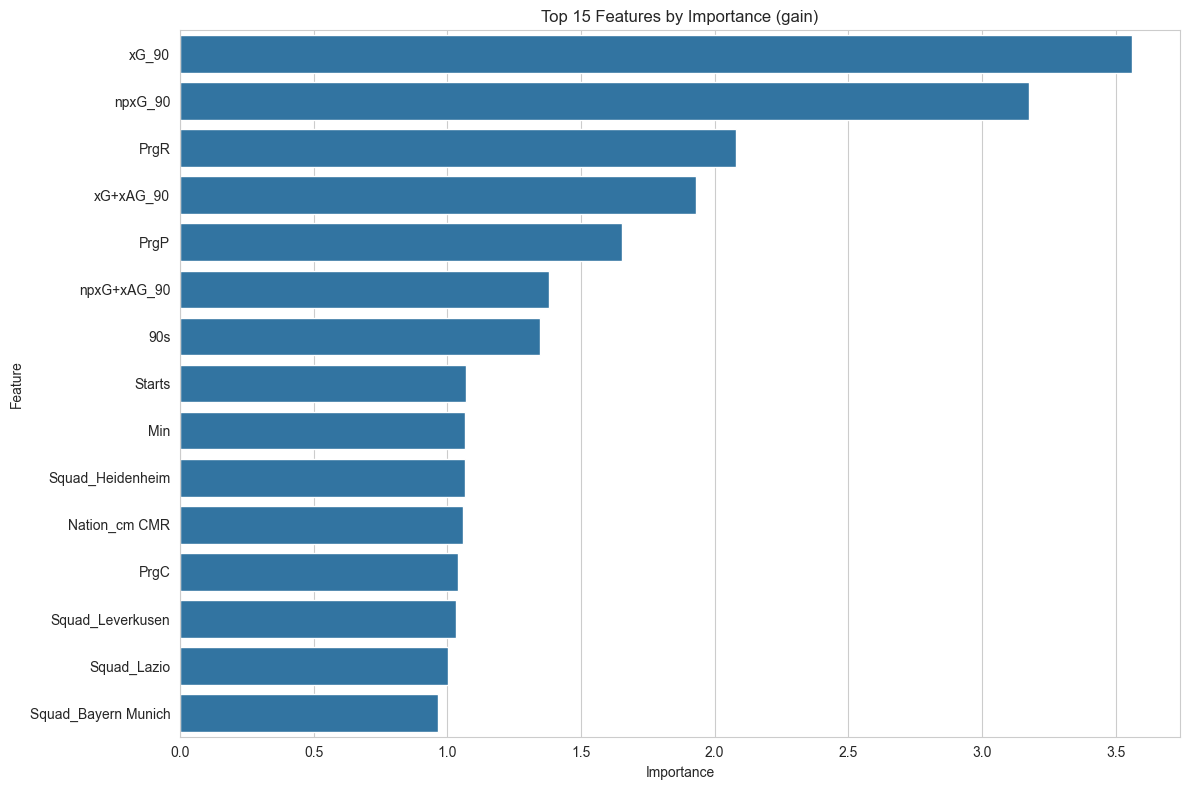

In [19]:
# Compute feature importance for tree-based models
print("Computing feature importance...")

if best_clf_name in ['RandomForestClassifier', 'XGBClassifier']:
    print(f"{best_clf_name} is tree-based, computing feature importance...")
    
    # Get the feature names after one-hot encoding
    # First, fit the preprocessor on the training data
    X_train_transformed = preprocessor.fit_transform(X_train)
    
    # Get the feature names
    feature_names = []
    
    # Get numerical feature names (these stay the same)
    for name in numerical_columns:
        feature_names.append(name)
    
    # Get one-hot encoded feature names
    ohe = preprocessor.named_transformers_['cat']
    for i, category in enumerate(categorical_columns):
        for category_value in ohe.categories_[i]:
            feature_names.append(f"{category}_{category_value}")
    
    # Extract feature importance
    if best_clf_name == 'RandomForestClassifier':
        # For RandomForest, use feature_importances_
        importances = best_clf.feature_importances_
        importance_type = "feature_importances_"
    else:  # XGBClassifier
        # For XGB, use booster.get_score(importance_type='gain')
        importance_dict = best_clf.get_booster().get_score(importance_type='gain')
        # Convert to array matching the feature order
        importances = np.zeros(len(feature_names))
        for key, value in importance_dict.items():
            # XGBoost feature names are f0, f1, etc.
            idx = int(key.replace('f', ''))
            if idx < len(importances):
                importances[idx] = value
        importance_type = "gain"
    
    # Create a DataFrame for easier sorting and visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Display top 15 features
    print("\nTop 15 features by importance:")
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Create a bar plot of the top 15 features
    plt.figure(figsize=(12, 8))
    top_15 = feature_importance_df.head(15)
    sns.barplot(x='Importance', y='Feature', data=top_15)
    plt.title(f'Top 15 Features by Importance ({importance_type})')
    plt.tight_layout()
    
    # Save the feature importance plot
    print("\nSaving feature importance plot to artifacts/feature_importance.png...")
    plt.savefig('artifacts/feature_importance.png')
    print("Feature importance plot saved successfully.")
    plt.show()
else:
    print(f"{best_clf_name} is not tree-based, skipping feature importance calculation.")


## 8. Model Serialization
Save the trained model for future use.


In [20]:
# Serialize the full preprocessing + best model pipeline with joblib
print("Serializing the full pipeline with joblib...")
joblib.dump(best_pipeline, "artifacts/position_classifier.joblib")
print("Pipeline saved to artifacts/position_classifier.joblib")

print("\nAll tasks completed successfully!")

Serializing the full pipeline with joblib...
Pipeline saved to artifacts/position_classifier.joblib

All tasks completed successfully!
